## Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import os

## Datasets Preparation

In [2]:
# Dataset and date
ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/20mar22/SalishSea_1d_20220320_20220320_grid_T.nc')
ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/20mar22/SalishSea_1d_20220320_20220320_biol_T.nc')
date = pd.DatetimeIndex(ds['time_counter'].values)

# Driver variables
temp = ds.votemper
saline = ds.vosaline
e3t = ds.e3t

# Biological variables
sil = ds_bio.silicon
nitr = ds_bio.nitrate
ammo = ds_bio.ammonium

# Phytoplankton variables
diat = ds_bio.diatoms
flag = ds_bio.flagellates

# Zooplankton variables
micro = ds_bio.microzooplankton
meso = ds_bio.mesozooplankton

# Open the mesh mask
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
mask = mesh.tmask.to_numpy()

# Applying the mask
temp = temp.where(mask==1)
saline = saline.where(mask==1)
e3t = e3t.where(mask==1)

sil = sil.where(mask==1)
nitr= nitr.where(mask==1)
ammo = ammo.where(mask==1)

flag = flag.where(mask==1)
diat = diat.where(mask==1)

micro = micro.where(mask==1)
meso = meso.where(mask==1)


## Integration

In [3]:

temp_i1 = (temp[0,0:15] * e3t[0,0:15]).sum('deptht', skipna = True, min_count = 15) / flag.deptht[14]
temp_i2 = (temp[0,15:27] * e3t[0,15:27]).sum('deptht', skipna = True, min_count = 12) / (flag.deptht[26] - flag.deptht[15])
saline_i1 = (saline[0,0:15] * e3t[0,0:15]).sum('deptht', skipna = True, min_count = 15) / flag.deptht[14]
saline_i2 = (saline[0,15:27] * e3t[0,15:27]).sum('deptht', skipna = True, min_count = 12) / (flag.deptht[26] - flag.deptht[15])

sil_i = (sil[0,0:27] * e3t[0,0:27]).sum('deptht', skipna = True, min_count = 27) / flag.deptht[26]
nitr_i = (nitr[0,0:27] * e3t[0,0:27]).sum('deptht', skipna = True, min_count = 27) / flag.deptht[26]
ammo_i = (ammo[0,0:27] * e3t[0,0:27]).sum('deptht', skipna = True, min_count = 27) / flag.deptht[26]

flag_i = (flag[0,0:27] * e3t[0,0:27]).sum('deptht', skipna = True, min_count = 27) / flag.deptht[26]
diat_i = (diat[0,0:27] * e3t[0,0:27]).sum('deptht', skipna = True, min_count = 27) / flag.deptht[26]

micro_i = (micro[0,0:27] * e3t[0,0:27]).sum('deptht', skipna = True, min_count = 27) / flag.deptht[26]
meso_i = (meso[0,0:27] * e3t[0,0:27]).sum('deptht', skipna = True, min_count = 27) / flag.deptht[26]

    # return (temp_i1, temp_i2, saline_i1, saline_i2, sil_i, nitr_i, ammo_i, flag_i, diat_i, micro_i, meso_i)

In [4]:
# Post processing 
inputs = np.stack([temp_i1.values.flatten(), temp_i2.values.flatten(), saline_i1.values.flatten(), saline_i2.values.flatten()])
indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1]) & ~np.isnan(inputs[2])& ~np.isnan(inputs[3])) 
inputs2 = inputs[:,indx[:,0]]
inputs2 = inputs2.transpose()

targets= sil_i.values.flatten()
targets2 = targets[indx]
targets2 = np.ravel(targets2)

# Regressor
X_train, X_test, y_train, y_test = train_test_split(inputs2, targets2, random_state=1)
regr = MLPRegressor(solver = 'lbfgs', max_iter=200).fit(X_train, y_train)
output = regr.predict(inputs2)



# Post processing
indx2 = np.full(inputs[0,:].size,np.nan)
indx2[indx[:,0]] = output
modeled = np.reshape(indx2,(898,398)) 

# Preparation of the dataarray 
modeled = xr.DataArray(modeled,
                coords = {'y': diat_i.y, 'x': diat_i.x},
                dims = ['y','x'],
                attrs=dict(description="mole_concentration_of_silicon_expressed_as_nitrogen_in_sea_water",
                            long_name ="Silicon Concentration",
                            units="mmol m-2"),
                )


/home/ibougoudis/conda_envs/analysis-ilias/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


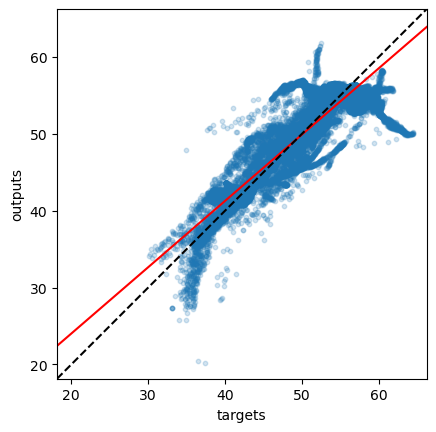

In [5]:
fig, ax = plt.subplots()

scatter = plt.scatter(targets2,output, alpha = 0.2, s = 10)
plt.xlabel('targets')
plt.ylabel('outputs')

# compute slope m and intercept b
m, b = np.polyfit(targets2, output, deg=1)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# plot fitted y = m*x + b
plt.axline(xy1=(0, b), slope=m, color='r')

ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.plot(lims, lims,linestyle = '--',color = 'k')

The correlation coefficient is: 0.9085124513004158
 The root mean square error is: 2.4867679146362995


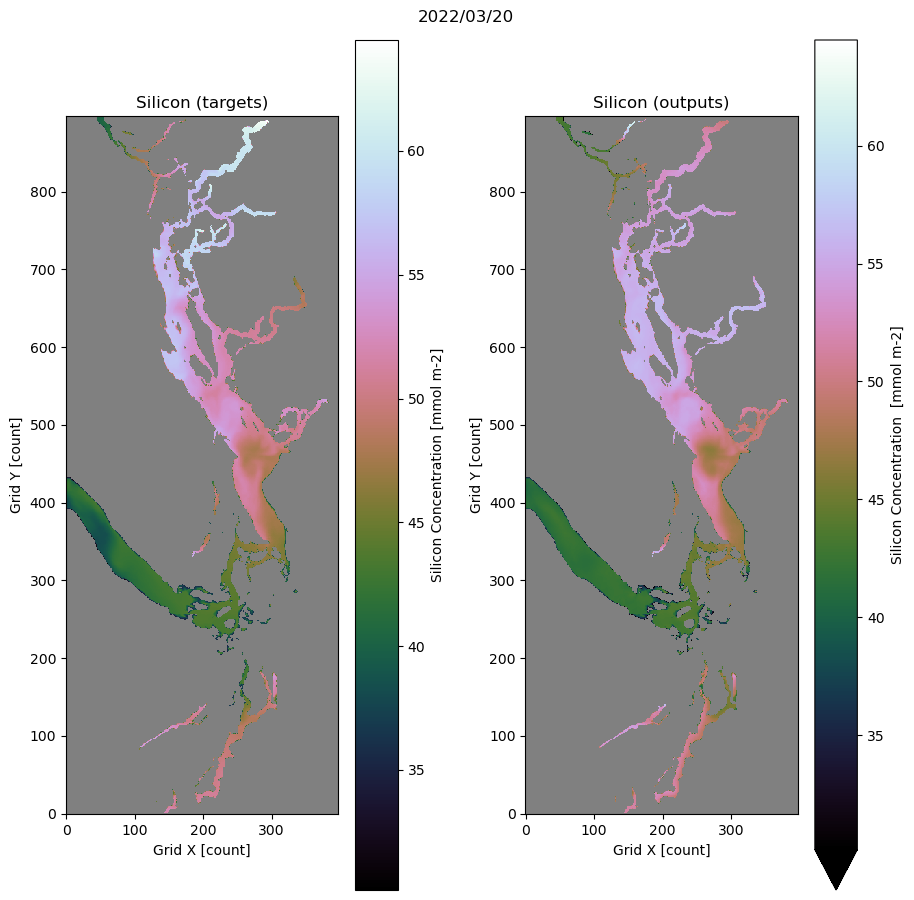

In [6]:
if date[0].month < 10:
    month = '0' + str(date[0].month)
else:
    month = str(date[0].month)

if date[0].day < 10:
    day = '0' + str(date[0].day)  
else:
    day = str(date[0].day) 

fig, ax = plt.subplots(1,2, figsize=(10, 10))

cmap = plt.get_cmap('cubehelix')
cmap.set_bad('gray')

test = sil_i.plot.pcolormesh(ax=ax[0], cmap=cmap, vmin = sil_i.min(), vmax = sil_i.max(), cbar_kwargs={'label': 'Silicon Concentration [mmol m-2]'})

modeled.plot.pcolormesh(ax=ax[1], cmap=cmap, vmin = sil_i.min(), vmax = sil_i.max(), cbar_kwargs={'label': 'Silicon Concentration  [mmol m-2]'})

plt.subplots_adjust(left=0.1,
    bottom=0.1, 
    right=0.9, 
    top=0.95, 
    wspace=0.35, 
    hspace=0.35)

sa_vi.set_aspect(ax[0])
sa_vi.set_aspect(ax[1])


ax[0].title.set_text('Silicon (targets)')
ax[1].title.set_text('Silicon (outputs)')


fig.suptitle(str(date[0].year) + '/' + month + '/' + day)

print ('The correlation coefficient is:', math.sqrt(regr.score(X_test, y_test)))

print(' The root mean square error is:', math.sqrt(mse(targets2,output)))


In [7]:
# Post processing 
inputs = np.stack([temp_i1.values.flatten(), temp_i2.values.flatten(), saline_i1.values.flatten(), saline_i2.values.flatten()])
indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1]) & ~np.isnan(inputs[2])& ~np.isnan(inputs[3])) 
inputs2 = inputs[:,indx[:,0]]
inputs2 = inputs2.transpose()

targets= nitr_i.values.flatten()
targets2 = targets[indx]
targets2 = np.ravel(targets2)

# Regressor
X_train, X_test, y_train, y_test = train_test_split(inputs2, targets2, random_state=1)
regr = MLPRegressor(solver = 'lbfgs', max_iter=200).fit(X_train, y_train)
output = regr.predict(inputs2)


# Post processing
indx2 = np.full(inputs[0,:].size,np.nan)
indx2[indx[:,0]] = output
modeled = np.reshape(indx2,(898,398)) 

# Preparation of the dataarray 
modeled = xr.DataArray(modeled,
                coords = {'y': diat_i.y, 'x': diat_i.x},
                dims = ['y','x'],
                attrs=dict(description="mole_concentration_of_nitrate_expressed_as_nitrogen_in_sea_water",
                            long_name ="Nitrate Concentration",
                            units="mmol m-2"),
                )


/home/ibougoudis/conda_envs/analysis-ilias/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


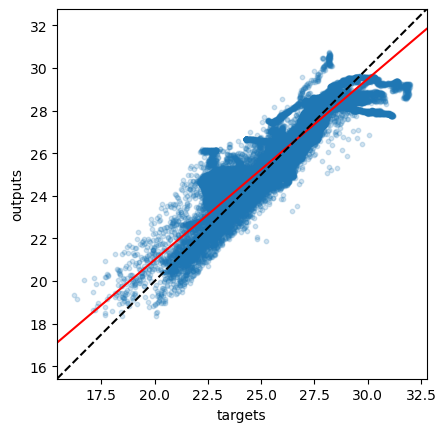

In [8]:
fig, ax = plt.subplots()

scatter = plt.scatter(targets2,output, alpha = 0.2, s = 10)
plt.xlabel('targets')
plt.ylabel('outputs')

# compute slope m and intercept b
m, b = np.polyfit(targets2, output, deg=1)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# plot fitted y = m*x + b
plt.axline(xy1=(0, b), slope=m, color='r')

ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.plot(lims, lims,linestyle = '--',color = 'k')

The correlation coefficient is: 0.9168464806944385
 The root mean square error is: 0.8301808064878289


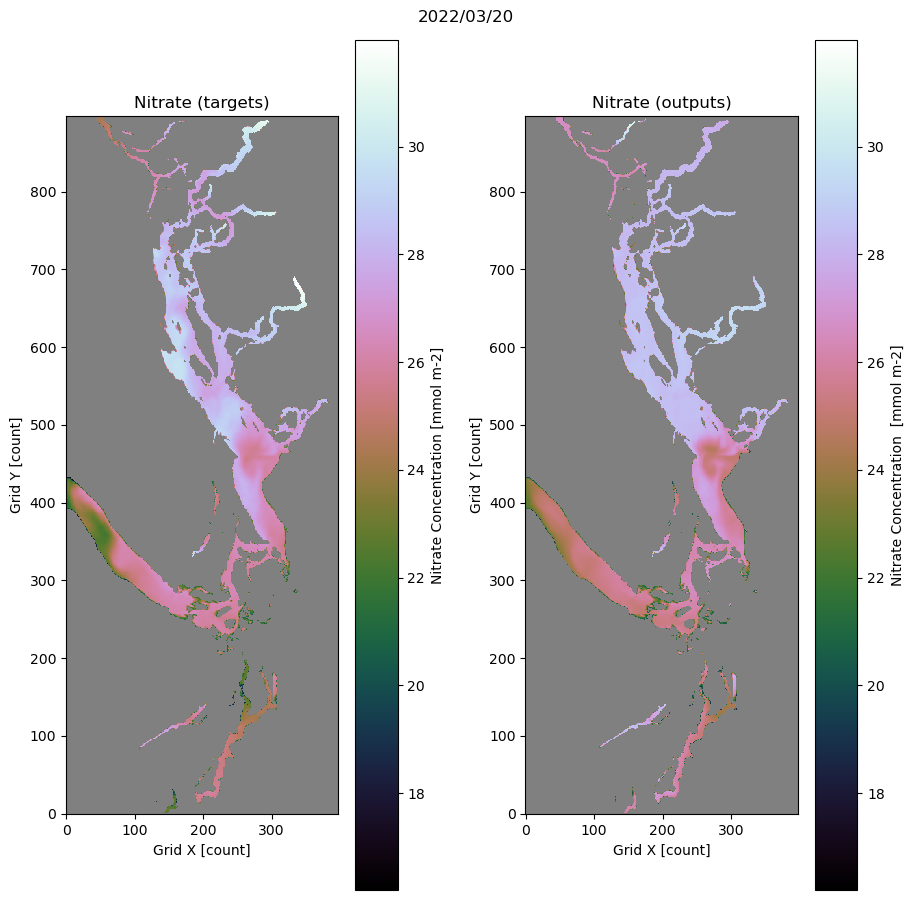

In [9]:
if date[0].month < 10:
    month = '0' + str(date[0].month)
else:
    month = str(date[0].month)

if date[0].day < 10:
    day = '0' + str(date[0].day)  
else:
    day = str(date[0].day) 

fig, ax = plt.subplots(1,2, figsize=(10, 10))

cmap = plt.get_cmap('cubehelix')
cmap.set_bad('gray')

nitr_i.plot.pcolormesh(ax=ax[0], cmap=cmap, vmin = nitr_i.min(), vmax = nitr_i.max(), cbar_kwargs={'label': 'Nitrate Concentration [mmol m-2]'})

modeled.plot.pcolormesh(ax=ax[1], cmap=cmap, vmin = nitr_i.min(), vmax = nitr_i.max(), cbar_kwargs={'label': 'Nitrate Concentration  [mmol m-2]'})

plt.subplots_adjust(left=0.1,
    bottom=0.1, 
    right=0.9, 
    top=0.95, 
    wspace=0.35, 
    hspace=0.35)

sa_vi.set_aspect(ax[0])
sa_vi.set_aspect(ax[1])


ax[0].title.set_text('Nitrate (targets)')
ax[1].title.set_text('Nitrate (outputs)')


fig.suptitle(str(date[0].year) + '/' + month + '/' + day)

print ('The correlation coefficient is:', math.sqrt(regr.score(X_test, y_test)))

print(' The root mean square error is:', math.sqrt(mse(targets2,output)))


In [10]:
# Post processing 
inputs = np.stack([temp_i1.values.flatten(), temp_i2.values.flatten(), saline_i1.values.flatten(), saline_i2.values.flatten()])
indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1]) & ~np.isnan(inputs[2])& ~np.isnan(inputs[3])) 
inputs2 = inputs[:,indx[:,0]]
inputs2 = inputs2.transpose()

targets= ammo_i.values.flatten()
targets2 = targets[indx]
targets2 = np.ravel(targets2)

# Regressor
X_train, X_test, y_train, y_test = train_test_split(inputs2, targets2, random_state=1)
regr = MLPRegressor(solver = 'lbfgs', max_iter=200).fit(X_train, y_train)
output = regr.predict(inputs2)


# Post processing
indx2 = np.full(inputs[0,:].size,np.nan)
indx2[indx[:,0]] = output
modeled = np.reshape(indx2,(898,398)) 

# Preparation of the dataarray 
modeled = xr.DataArray(modeled,
                coords = {'y': diat_i.y, 'x': diat_i.x},
                dims = ['y','x'],
                attrs=dict(description="mole_concentration_of_ammonium_expressed_as_nitrogen_in_sea_water",
                            long_name ="Ammonium Concentration",
                            units="mmol m-2"),
                )


/home/ibougoudis/conda_envs/analysis-ilias/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


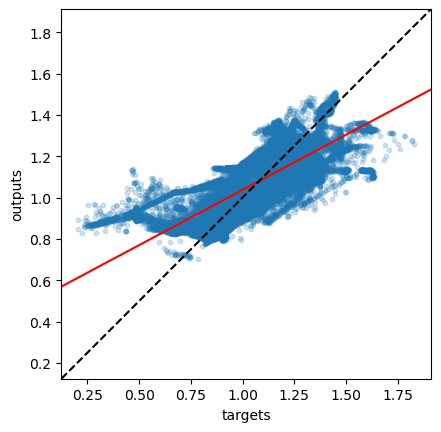

In [11]:
fig, ax = plt.subplots()

scatter = plt.scatter(targets2,output, alpha = 0.2, s = 10)
plt.xlabel('targets')
plt.ylabel('outputs')

# compute slope m and intercept b
m, b = np.polyfit(targets2, output, deg=1)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# plot fitted y = m*x + b
plt.axline(xy1=(0, b), slope=m, color='r')

ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.plot(lims, lims,linestyle = '--',color = 'k')

The correlation coefficient is: 0.7434633725593507
 The root mean square error is: 0.1343026148441989


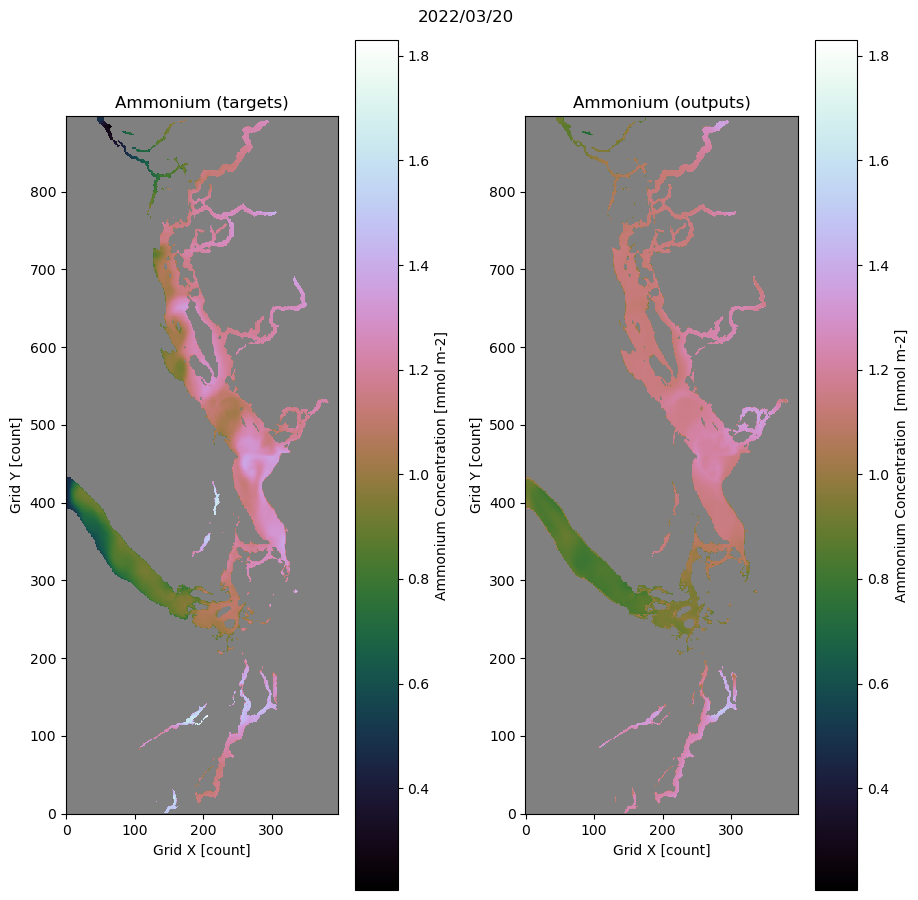

In [12]:
if date[0].month < 10:
    month = '0' + str(date[0].month)
else:
    month = str(date[0].month)

if date[0].day < 10:
    day = '0' + str(date[0].day)  
else:
    day = str(date[0].day) 

fig, ax = plt.subplots(1,2, figsize=(10, 10))

cmap = plt.get_cmap('cubehelix')
cmap.set_bad('gray')

ammo_i.plot.pcolormesh(ax=ax[0], cmap=cmap, vmin = ammo_i.min(), vmax = ammo_i.max(), cbar_kwargs={'label': 'Ammonium Concentration [mmol m-2]'})

modeled.plot.pcolormesh(ax=ax[1], cmap=cmap, vmin = ammo_i.min(), vmax = ammo_i.max(), cbar_kwargs={'label': 'Ammonium Concentration  [mmol m-2]'})

plt.subplots_adjust(left=0.1,
    bottom=0.1, 
    right=0.9, 
    top=0.95, 
    wspace=0.35, 
    hspace=0.35)

sa_vi.set_aspect(ax[0])
sa_vi.set_aspect(ax[1])


ax[0].title.set_text('Ammonium (targets)')
ax[1].title.set_text('Ammonium (outputs)')


fig.suptitle(str(date[0].year) + '/' + month + '/' + day)

print ('The correlation coefficient is:', math.sqrt(regr.score(X_test, y_test)))

print(' The root mean square error is:', math.sqrt(mse(targets2,output)))


In [13]:
# Post processing 
inputs = np.stack([temp_i1.values.flatten(), temp_i2.values.flatten(), saline_i1.values.flatten(), saline_i2.values.flatten()])
indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1]) & ~np.isnan(inputs[2])& ~np.isnan(inputs[3])) 
inputs2 = inputs[:,indx[:,0]]
inputs2 = inputs2.transpose()

targets= diat_i.values.flatten()
targets2 = targets[indx]
targets2 = np.ravel(targets2)

# Regressor
X_train, X_test, y_train, y_test = train_test_split(inputs2, targets2, random_state=1)
regr = MLPRegressor(solver = 'lbfgs', max_iter=200).fit(X_train, y_train)
output = regr.predict(inputs2)


# Post processing
indx2 = np.full(inputs[0,:].size,np.nan)
indx2[indx[:,0]] = output
modeled = np.reshape(indx2,(898,398)) 

# Preparation of the dataarray 
modeled = xr.DataArray(modeled,
                coords = {'y': diat_i.y, 'x': diat_i.x},
                dims = ['y','x'],
                attrs=dict(description="mole_concentration_of_diatom_expressed_as_nitrogen_in_sea_water",
                            long_name ="Diatom Concentration",
                            units="mmol m-2"),
                )


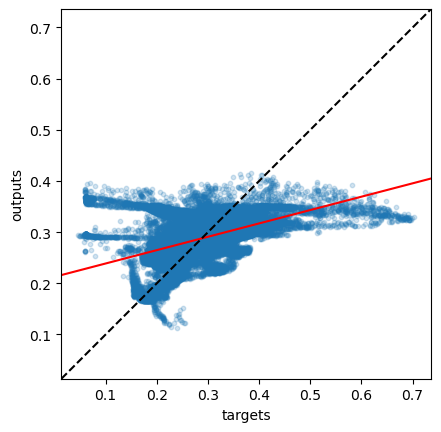

In [14]:
fig, ax = plt.subplots()

scatter = plt.scatter(targets2,output, alpha = 0.2, s = 10)
plt.xlabel('targets')
plt.ylabel('outputs')

# compute slope m and intercept b
m, b = np.polyfit(targets2, output, deg=1)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# plot fitted y = m*x + b
plt.axline(xy1=(0, b), slope=m, color='r')

ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.plot(lims, lims,linestyle = '--',color = 'k')

The correlation coefficient is: 0.5027375148800224
 The root mean square error is: 0.06630781931981349


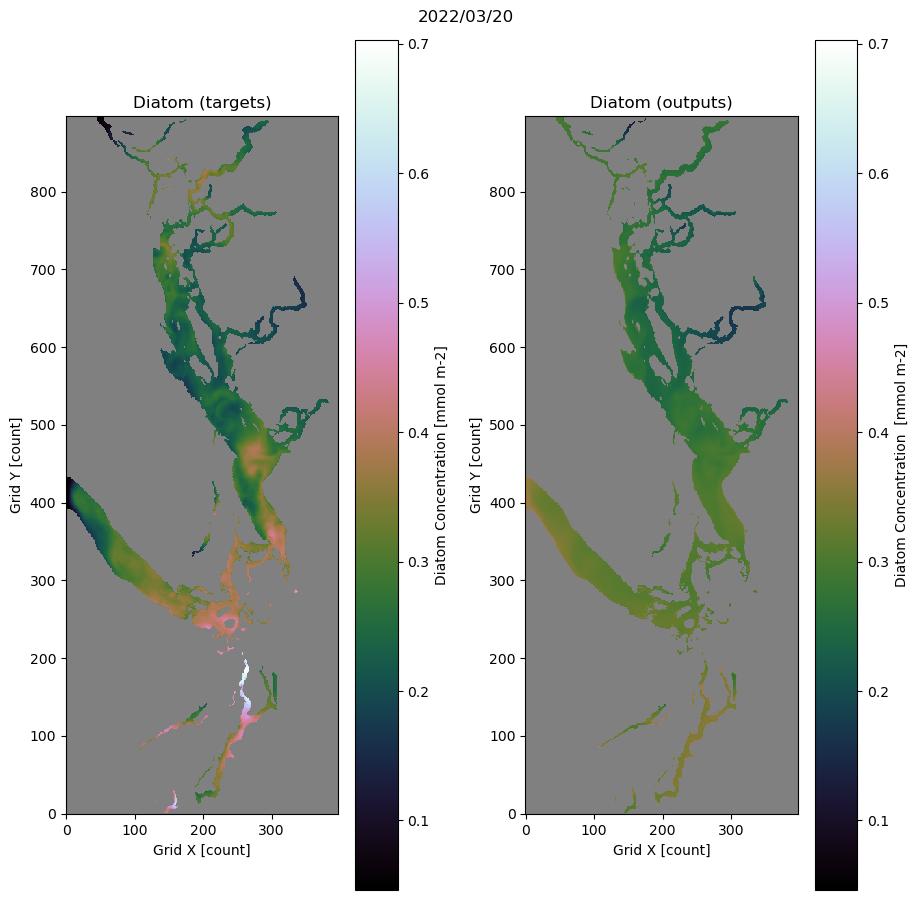

In [15]:
if date[0].month < 10:
    month = '0' + str(date[0].month)
else:
    month = str(date[0].month)

if date[0].day < 10:
    day = '0' + str(date[0].day)  
else:
    day = str(date[0].day) 

fig, ax = plt.subplots(1,2, figsize=(10, 10))

cmap = plt.get_cmap('cubehelix')
cmap.set_bad('gray')

diat_i.plot.pcolormesh(ax=ax[0], cmap=cmap, vmin = diat_i.min(), vmax = diat_i.max(), cbar_kwargs={'label': 'Diatom Concentration [mmol m-2]'})

modeled.plot.pcolormesh(ax=ax[1], cmap=cmap, vmin = diat_i.min(), vmax = diat_i.max(), cbar_kwargs={'label': 'Diatom Concentration  [mmol m-2]'})

plt.subplots_adjust(left=0.1,
    bottom=0.1, 
    right=0.9, 
    top=0.95, 
    wspace=0.35, 
    hspace=0.35)

sa_vi.set_aspect(ax[0])
sa_vi.set_aspect(ax[1])


ax[0].title.set_text('Diatom (targets)')
ax[1].title.set_text('Diatom (outputs)')


fig.suptitle(str(date[0].year) + '/' + month + '/' + day)

print ('The correlation coefficient is:', math.sqrt(regr.score(X_test, y_test)))

print(' The root mean square error is:', math.sqrt(mse(targets2,output)))


In [16]:
# Post processing 
inputs = np.stack([temp_i1.values.flatten(), temp_i2.values.flatten(), saline_i1.values.flatten(), saline_i2.values.flatten()])
indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1]) & ~np.isnan(inputs[2])& ~np.isnan(inputs[3])) 
inputs2 = inputs[:,indx[:,0]]
inputs2 = inputs2.transpose()

targets= flag_i.values.flatten()
targets2 = targets[indx]
targets2 = np.ravel(targets2)

# Regressor
X_train, X_test, y_train, y_test = train_test_split(inputs2, targets2, random_state=1)
regr = MLPRegressor(solver = 'lbfgs', max_iter=200).fit(X_train, y_train)
output = regr.predict(inputs2)


# Post processing
indx2 = np.full(inputs[0,:].size,np.nan)
indx2[indx[:,0]] = output
modeled = np.reshape(indx2,(898,398)) 

# Preparation of the dataarray 
modeled = xr.DataArray(modeled,
                coords = {'y': diat_i.y, 'x': diat_i.x},
                dims = ['y','x'],
                attrs=dict(description="mole_concentration_of_flagellate_expressed_as_nitrogen_in_sea_water",
                            long_name ="Flagellate Concentration",
                            units="mmol m-2"),
                )


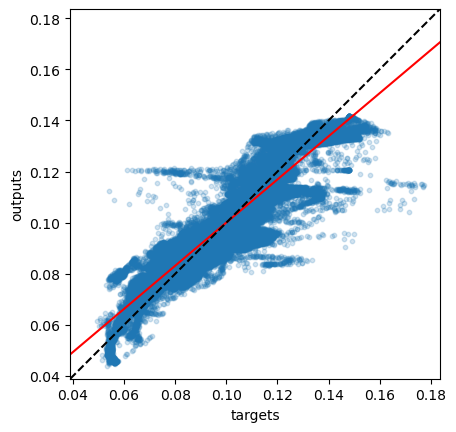

In [17]:
fig, ax = plt.subplots()

scatter = plt.scatter(targets2,output, alpha = 0.2, s = 10)
plt.xlabel('targets')
plt.ylabel('outputs')

# compute slope m and intercept b
m, b = np.polyfit(targets2, output, deg=1)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# plot fitted y = m*x + b
plt.axline(xy1=(0, b), slope=m, color='r')

ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.plot(lims, lims,linestyle = '--',color = 'k')

The correlation coefficient is: 0.9142924024159834
 The root mean square error is: 0.009304395471923223


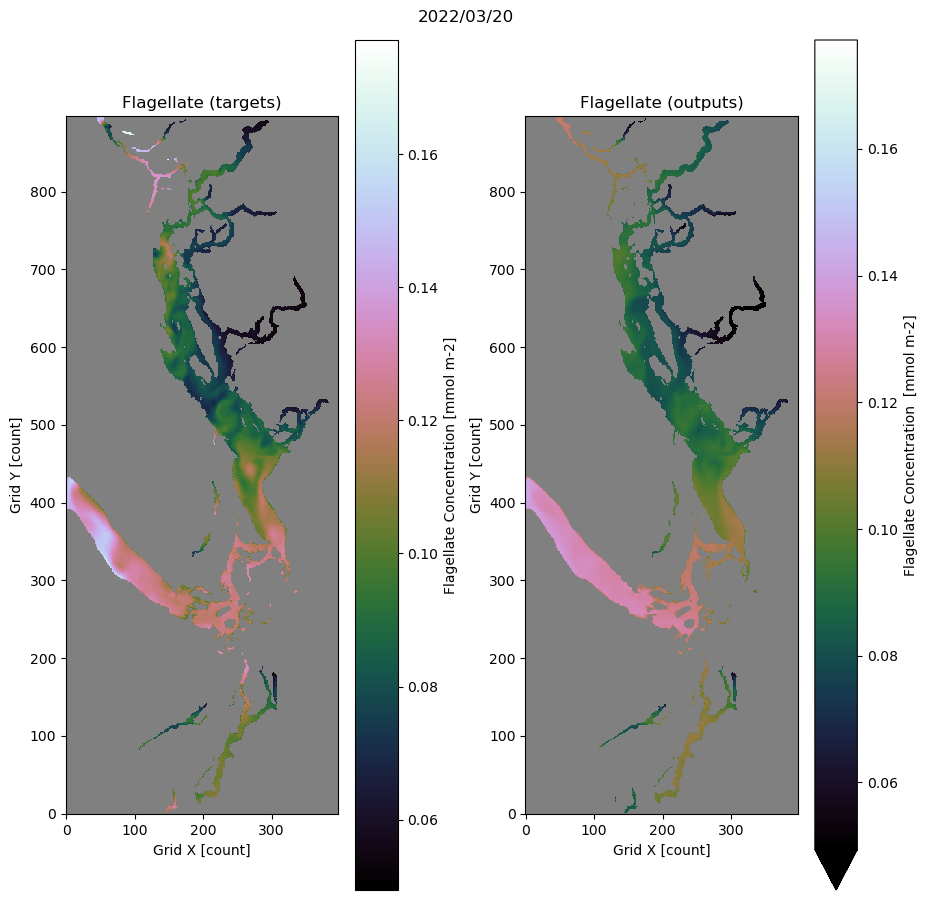

In [18]:
if date[0].month < 10:
    month = '0' + str(date[0].month)
else:
    month = str(date[0].month)

if date[0].day < 10:
    day = '0' + str(date[0].day)  
else:
    day = str(date[0].day) 

fig, ax = plt.subplots(1,2, figsize=(10, 10))

cmap = plt.get_cmap('cubehelix')
cmap.set_bad('gray')

flag_i.plot.pcolormesh(ax=ax[0], cmap=cmap, vmin = flag_i.min(), vmax = flag_i.max(), cbar_kwargs={'label': 'Flagellate Concentration [mmol m-2]'})

modeled.plot.pcolormesh(ax=ax[1], cmap=cmap, vmin = flag_i.min(), vmax = flag_i.max(), cbar_kwargs={'label': 'Flagellate Concentration  [mmol m-2]'})

plt.subplots_adjust(left=0.1,
    bottom=0.1, 
    right=0.9, 
    top=0.95, 
    wspace=0.35, 
    hspace=0.35)

sa_vi.set_aspect(ax[0])
sa_vi.set_aspect(ax[1])


ax[0].title.set_text('Flagellate (targets)')
ax[1].title.set_text('Flagellate (outputs)')


fig.suptitle(str(date[0].year) + '/' + month + '/' + day)

print ('The correlation coefficient is:', math.sqrt(regr.score(X_test, y_test)))

print(' The root mean square error is:', math.sqrt(mse(targets2,output)))


In [19]:
# Post processing 
inputs = np.stack([temp_i1.values.flatten(), temp_i2.values.flatten(), saline_i1.values.flatten(), saline_i2.values.flatten()])
indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1]) & ~np.isnan(inputs[2])& ~np.isnan(inputs[3])) 
inputs2 = inputs[:,indx[:,0]]
inputs2 = inputs2.transpose()

targets= micro_i.values.flatten()
targets2 = targets[indx]
targets2 = np.ravel(targets2)

# Regressor
X_train, X_test, y_train, y_test = train_test_split(inputs2, targets2, random_state=1)
regr = MLPRegressor(solver = 'lbfgs', max_iter=200).fit(X_train, y_train)
output = regr.predict(inputs2)


# Post processing
indx2 = np.full(inputs[0,:].size,np.nan)
indx2[indx[:,0]] = output
modeled = np.reshape(indx2,(898,398)) 

# Preparation of the dataarray 
modeled = xr.DataArray(modeled,
                coords = {'y': diat_i.y, 'x': diat_i.x},
                dims = ['y','x'],
                attrs=dict(description="mole_concentration_of_microzooplankton_expressed_as_nitrogen_in_sea_water",
                            long_name ="Microzooplankton Concentration",
                            units="mmol m-2"),
                )


/home/ibougoudis/conda_envs/analysis-ilias/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


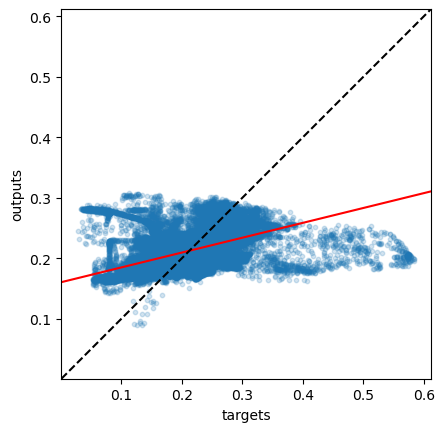

In [20]:
fig, ax = plt.subplots()

scatter = plt.scatter(targets2,output, alpha = 0.2, s = 10)
plt.xlabel('targets')
plt.ylabel('outputs')

# compute slope m and intercept b
m, b = np.polyfit(targets2, output, deg=1)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# plot fitted y = m*x + b
plt.axline(xy1=(0, b), slope=m, color='r')

ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.plot(lims, lims,linestyle = '--',color = 'k')

The correlation coefficient is: 0.4866207129335599
 The root mean square error is: 0.05888210616614162


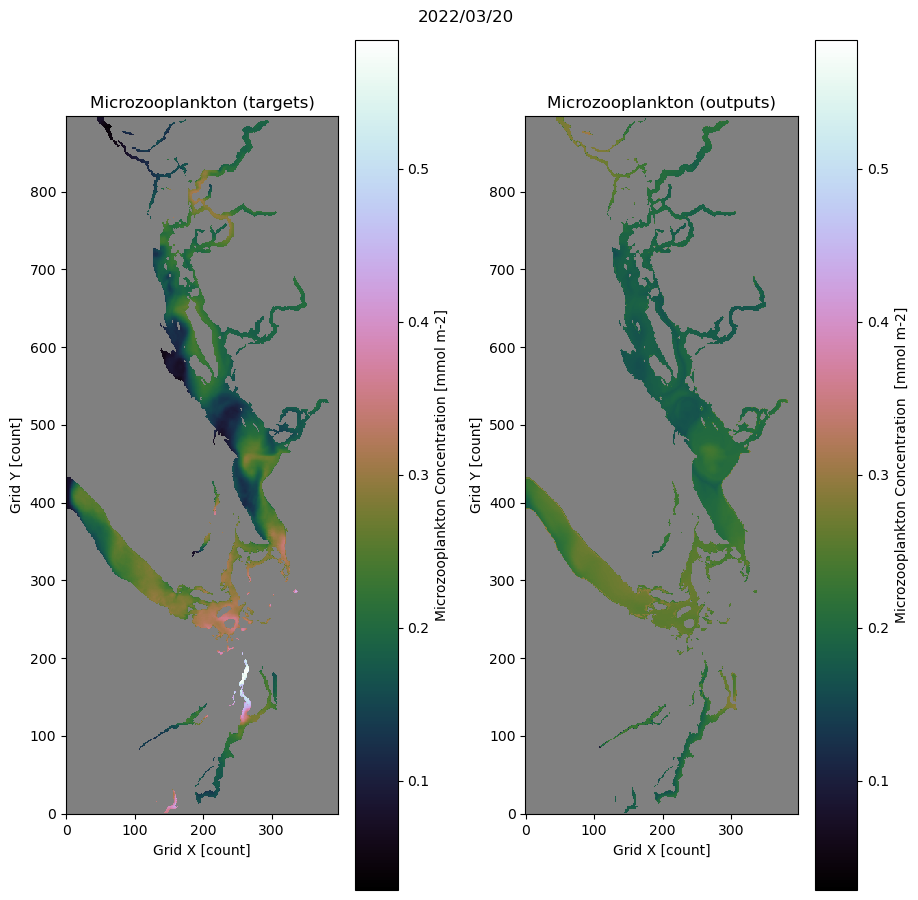

In [21]:
if date[0].month < 10:
    month = '0' + str(date[0].month)
else:
    month = str(date[0].month)

if date[0].day < 10:
    day = '0' + str(date[0].day)  
else:
    day = str(date[0].day) 

fig, ax = plt.subplots(1,2, figsize=(10, 10))

cmap = plt.get_cmap('cubehelix')
cmap.set_bad('gray')

micro_i.plot.pcolormesh(ax=ax[0], cmap=cmap, vmin = micro_i.min(), vmax = micro_i.max(), cbar_kwargs={'label': 'Microzooplankton Concentration [mmol m-2]'})

modeled.plot.pcolormesh(ax=ax[1], cmap=cmap, vmin = micro_i.min(), vmax = micro_i.max(), cbar_kwargs={'label': 'Microzooplankton Concentration  [mmol m-2]'})

plt.subplots_adjust(left=0.1,
    bottom=0.1, 
    right=0.9, 
    top=0.95, 
    wspace=0.35, 
    hspace=0.35)

sa_vi.set_aspect(ax[0])
sa_vi.set_aspect(ax[1])


ax[0].title.set_text('Microzooplankton (targets)')
ax[1].title.set_text('Microzooplankton (outputs)')


fig.suptitle(str(date[0].year) + '/' + month + '/' + day)

print ('The correlation coefficient is:', math.sqrt(regr.score(X_test, y_test)))

print(' The root mean square error is:', math.sqrt(mse(targets2,output)))


In [22]:
# Post processing 
inputs = np.stack([temp_i1.values.flatten(), temp_i2.values.flatten(), saline_i1.values.flatten(), saline_i2.values.flatten()])
indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1]) & ~np.isnan(inputs[2])& ~np.isnan(inputs[3])) 
inputs2 = inputs[:,indx[:,0]]
inputs2 = inputs2.transpose()

targets= meso_i.values.flatten()
targets2 = targets[indx]
targets2 = np.ravel(targets2)

# Regressor
X_train, X_test, y_train, y_test = train_test_split(inputs2, targets2, random_state=1)
regr = MLPRegressor(solver = 'lbfgs', max_iter=200).fit(X_train, y_train)
output = regr.predict(inputs2)


# Post processing
indx2 = np.full(inputs[0,:].size,np.nan)
indx2[indx[:,0]] = output
modeled = np.reshape(indx2,(898,398)) 

# Preparation of the dataarray 
modeled = xr.DataArray(modeled,
                coords = {'y': diat_i.y, 'x': diat_i.x},
                dims = ['y','x'],
                attrs=dict(description="mole_concentration_of_mesozooplankton_expressed_as_nitrogen_in_sea_water",
                            long_name ="Mesozooplankton Concentration",
                            units="mmol m-2"),
                )


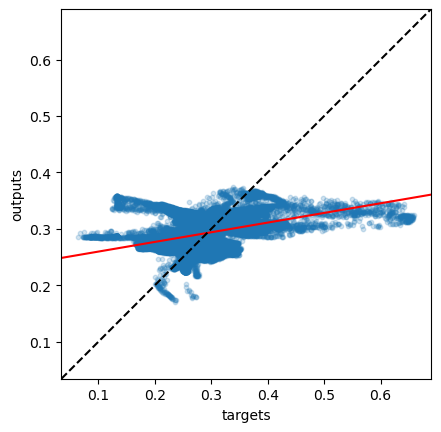

In [23]:
fig, ax = plt.subplots()

scatter = plt.scatter(targets2,output, alpha = 0.2, s = 10)
plt.xlabel('targets')
plt.ylabel('outputs')

# compute slope m and intercept b
m, b = np.polyfit(targets2, output, deg=1)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# plot fitted y = m*x + b
plt.axline(xy1=(0, b), slope=m, color='r')

ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.plot(lims, lims,linestyle = '--',color = 'k')

The correlation coefficient is: 0.4065362753348649
 The root mean square error is: 0.057884966662968405


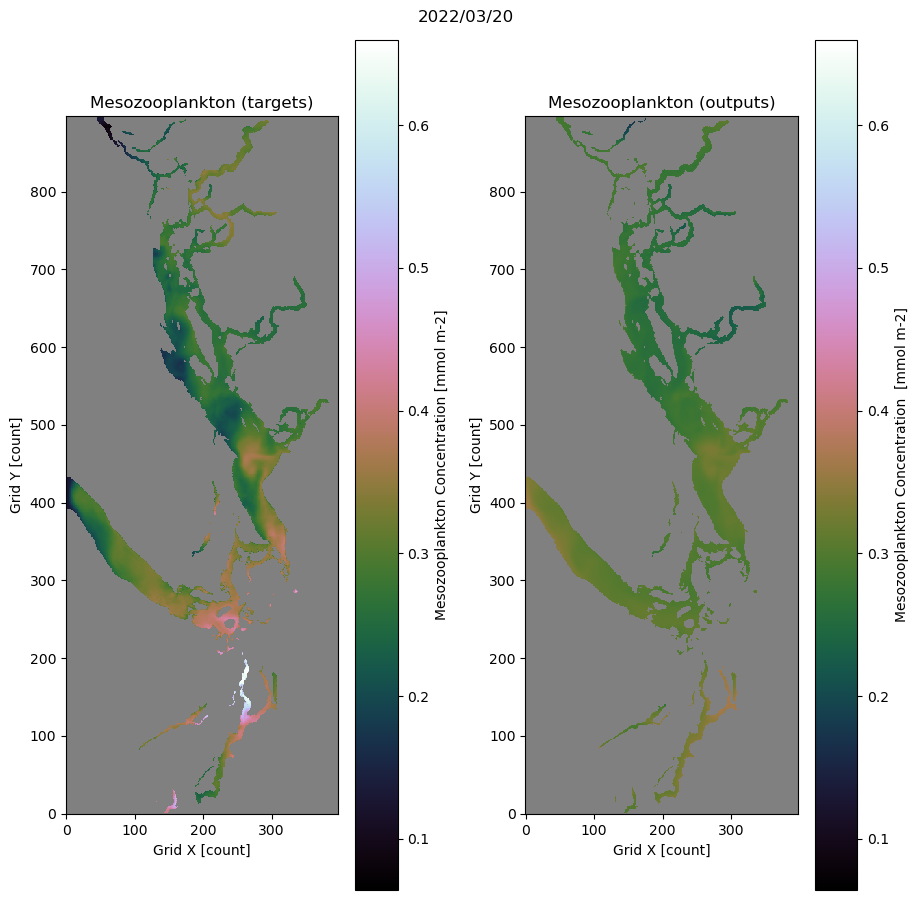

In [24]:
if date[0].month < 10:
    month = '0' + str(date[0].month)
else:
    month = str(date[0].month)

if date[0].day < 10:
    day = '0' + str(date[0].day)  
else:
    day = str(date[0].day) 

fig, ax = plt.subplots(1,2, figsize=(10, 10))

cmap = plt.get_cmap('cubehelix')
cmap.set_bad('gray')

meso_i.plot.pcolormesh(ax=ax[0], cmap=cmap, vmin = meso_i.min(), vmax = meso_i.max(), cbar_kwargs={'label': 'Mesozooplankton Concentration [mmol m-2]'})

modeled.plot.pcolormesh(ax=ax[1], cmap=cmap, vmin = meso_i.min(), vmax = meso_i.max(), cbar_kwargs={'label': 'Mesozooplankton Concentration  [mmol m-2]'})

plt.subplots_adjust(left=0.1,
    bottom=0.1, 
    right=0.9, 
    top=0.95, 
    wspace=0.35, 
    hspace=0.35)

sa_vi.set_aspect(ax[0])
sa_vi.set_aspect(ax[1])


ax[0].title.set_text('Mesozooplankton (targets)')
ax[1].title.set_text('Mesozooplankton (outputs)')


fig.suptitle(str(date[0].year) + '/' + month + '/' + day)

print ('The correlation coefficient is:', math.sqrt(regr.score(X_test, y_test)))

print(' The root mean square error is:', math.sqrt(mse(targets2,output)))
